# First model: simple linear regression

In [45]:
import jax
import numpyro
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import chainconsumer
from chainconsumer import ChainConsumer, Chain

First, we generate a simple linear model:
$$ y(x) = m \cdot x + c$$

where we take $m = 2$ and $c = 3.5$. But also add some complications: `ebar` and `scatter`: average and spread of the size of errorbars, using a Poisson distribution.

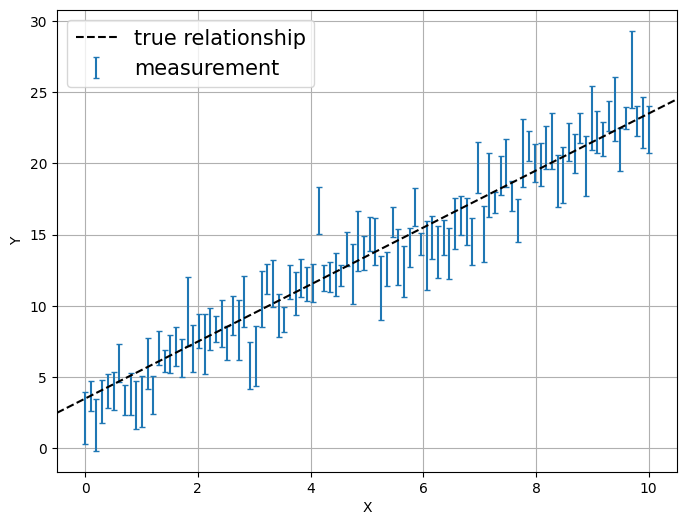

In [24]:
# Model true parameters
m_true = 2
c_true = 3.5

# Generate realistic data
n_data = 100
ebar, escatter = 1.5, 10

np.random.seed(123)
X = np.linspace(0, 10, n_data)
E = np.random.poisson(lam=escatter, size=n_data) / escatter * ebar
Y = m_true * X + c_true + E * np.random.normal(size=n_data)

# Plot data and errorbars
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(X, Y, E, fmt='none', capsize=2, label='measurement')
ax.axline([0, c_true], slope=m_true, c='k', ls='--', label='true relationship')
ax.legend(loc='best', fontsize=15)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()

plt.show()

Goal: recover $m$ and $c$ using NumPyro. Assuming the measurements are uncorrelated, the likelihood:
$$ \mathcal{L} (m, c|y_i) = \exp\left(-\frac{\chi^2}{2}\right) = \exp\left[-\frac{1}{2}\sum_i\left(\frac{y_i - (m \cdot x_i + c)}{E_i}\right)^2\right]$$

Take our priors on $m$ and $c$ to be uniform and sufficiently broad:
$$m \sim \mathcal{U}(-5, 5)$$
$$c \sim \mathcal{U}(-10, 10)$$

In [25]:
# Define the model
def model(X, Y, E):

    # Our priors on m and c
    m = numpyro.sample('m', numpyro.distributions.Uniform(-5, 5))
    c = numpyro.sample('c', numpyro.distributions.Uniform(-10, 10))

    with numpyro.plate('data', len(X)):
        y_model = m * X + c
        numpyro.sample('y', numpyro.distributions.Normal(y_model, E), obs=Y)

- First two lines in the function: our priors.
    - First argument: 'site name' -> unique name that NumPyro will internally recognise as this variable and returns its results as
    - The variables themselves are only for using them within the function (like when we calculate y_model)
- The 'plate' describes the way we sweep over the data points in $\sum_i (y_i - y_\mathrm{model})$
    - Everything created or called inside the plate is implicitly vectorized. For example, `X` means `X[i]`.
    - The sample `y` follows a normal distribution $y \sim \mathcal{N}(y_\mathrm{model}, E)$, and `obs=Y` means this distribution is being compared to the measurement `Y[i]`.
    - We do not store the sample `y` because it is not used for calculations.

To do MCMC, create an `MCMC` object and trigger it with the `.run` method:

In [48]:
sampler = numpyro.infer.MCMC(numpyro.infer.NUTS(model),
                             num_chains=1,
                             num_samples=5000,
                             num_warmup=500
                             )

sampler.run(jax.random.PRNGKey(1), X, Y, E)

sample: 100%|██████████| 5500/5500 [00:01<00:00, 4460.47it/s, 11 steps of size 2.86e-01. acc. prob=0.95]


First argument: what kind of MCMC sampler we use (in this case the No U-Turn Sampler (NUTS)). Can swap with a different sampler.

MCMC is a random process -> need to feed it a random seed. Takes the form of the `jax.random.PRNGKey(i)` argument. We also feed the data into the sampler when running, so the same model can be used for fitting multiple data sets.

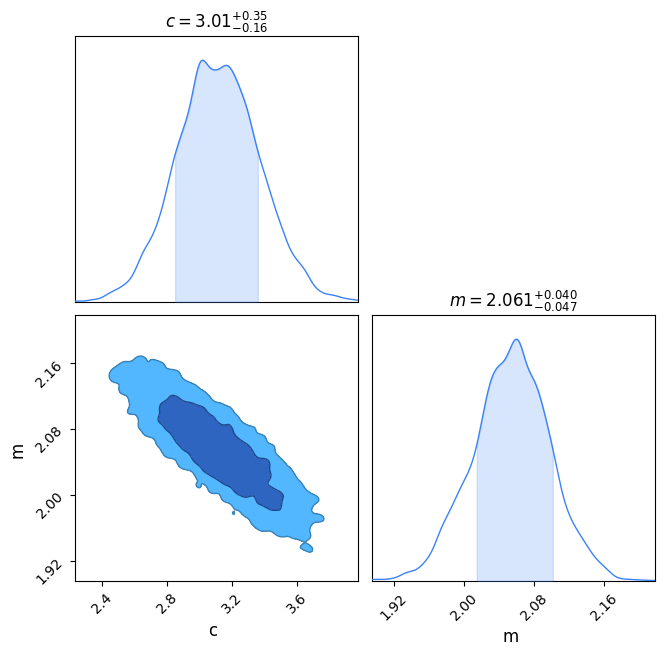

In [49]:
results = sampler.get_samples()
df = pd.DataFrame(results)
C = ChainConsumer()
C.add_chain(Chain(samples=df, name="An Example Contour"))
C.plotter.plot(
)

plt.show()

In [44]:
df = pd.DataFrame(results)

df

,c,m
0,3.341265,2.015788
1,3.465648,1.994773
2,2.735575,2.087350
3,2.976720,2.123702
4,3.013068,2.041830
...,...,...
995,3.002135,2.082963
996,3.043522,2.095135
997,2.978964,2.089131
998,3.016865,2.083285


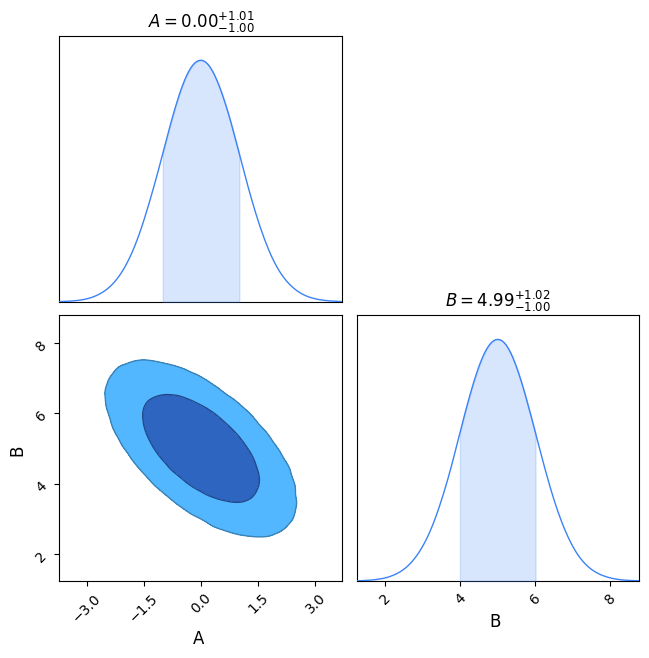

In [36]:
from chainconsumer import Chain, make_sample

df = make_sample()
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
fig = c.plotter.plot()

In [51]:
import emcee